In [1]:
import SimPEG as simpeg
import simpegMT as simpegmt
import numpy as np, os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Setup the modelling
# Setting up 1D mesh and conductivity models to forward model data.

# Frequency
nFreq = 31
freqs = np.logspace(3,-3,nFreq)
# Set mesh parameters
ct = 20
air = simpeg.Utils.meshTensor([(ct,16,1.4)])
core = np.concatenate( (  np.kron(simpeg.Utils.meshTensor([(ct,10,-1.3)]),np.ones((5,))) , simpeg.Utils.meshTensor([(ct,5)]) ) )
bot = simpeg.Utils.meshTensor([(core[0],10,-1.4)])
x0 = -np.array([np.sum(np.concatenate((core,bot)))])
# Make the model
m1d = simpeg.Mesh.TensorMesh([np.concatenate((bot,core,air))], x0=x0)

# Setup model varibles
active = m1d.vectorCCx<0.
layer1 = (m1d.vectorCCx<-500.) & (m1d.vectorCCx>=-800.)
layer2 = (m1d.vectorCCx<-3500.) & (m1d.vectorCCx>=-5000.)
# Set the conductivity values
sig_half = 2e-3
sig_air = 1e-8
sig_layer1 = .2
sig_layer2 = .2
# Make the true model
sigma_true = np.ones(m1d.nCx)*sig_air
sigma_true[active] = sig_half
sigma_true[layer1] = sig_layer1
sigma_true[layer2] = sig_layer2
# Extract the model 
m_true = np.log(sigma_true[active])
# Make the background model
sigma_0 = np.ones(m1d.nCx)*sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

# Set the mapping
actMap = simpeg.Maps.ActiveCells(m1d, active, np.log(1e-8), nC=m1d.nCx)
mappingExpAct = simpeg.Maps.ExpMap(m1d) * actMap

In [3]:
## Setup the layout of the survey, set the sources and the connected receivers

# Receivers 
rxList = []
for rxType in ['z1dr','z1di']:
    rxList.append(simpegmt.SurveyMT.RxMT(simpeg.mkvc(np.array([0.0]),2).T,rxType))
# Source list
srcList =[]
for freq in freqs:
        srcList.append(simpegmt.SurveyMT.srcMT_polxy_1Dprimary(rxList,freq))
# Make the survey
survey = simpegmt.SurveyMT.SurveyMT(srcList)
survey.mtrue = m_true
# Set the problem
problem = simpegmt.ProblemMT1D.eForm_psField(m1d,sigmaPrimary=sigma_0,mapping=mappingExpAct)
from pymatsolver import MumpsSolver
problem.solver = MumpsSolver
problem.pair(survey)

In [4]:
## Forward model observed data 
# Project the data
std = 0.05 # 5% std
if os.path.isfile('MT1D_dtrue.npy') and os.path.isfile('MT1D_dobs.npy'):
    d_true = np.load('MT1D_dtrue.npy')
    d_obs = np.load('MT1D_dobs.npy')
else:
    d_true = survey.dpred(m_true)
    np.save('MT1D_dtrue.npy',d_true)
    d_obs = d_true + std*abs(d_true)*np.random.randn(*d_true.shape)
    np.save('MT1D_dobs.npy',d_obs)
# Assign the dobs
survey.dtrue = d_true
survey.dobs = d_obs
survey.std = np.abs(survey.dobs*std) + 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Assign the data weight
survey.Wd = 1/survey.std #(abs(survey.dobs)*survey.std)

In [5]:
## Setup the inversion proceedure

# Define a counter
C =  simpeg.Utils.Counter()
# Set the optimization
opt = simpeg.Optimization.InexactGaussNewton(maxIter = 50)
opt.counter = C
opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
# Either have to use 
if True:
    regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]],m1d.x0)
    reg = simpeg.Regularization.Tikhonov(regMesh)
else:
    reg = simpeg.Regularization.Tikhonov(m1d,mapping=mappingExpAct)
reg.smoothModel = True
reg.alpha_s = 1e-7
reg.alpha_x = 1.

# Inversion problem
invProb = simpeg.InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta cooling
beta = simpeg.Directives.BetaSchedule()
betaest = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
targmis = simpeg.Directives.TargetMisfit()
saveModel = simpeg.Directives.SaveModelEveryIteration()
saveModel.fileName = 'Inversion_TargMisEqnD_smoothTrue'
# Create an inversion object
inv = simpeg.Inversion.BaseInversion(invProb, directiveList=[beta,betaest,targmis,saveModel]) 


In [6]:
%timeit
# Run the inversion, given the background model as a start.
mopt = inv.run(m_0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_TargMisEqnD_smoothTrue.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.78e+05  2.18e+05  0.00e+00  2.18e+05    4.01e+04      0              
   1  2.78e+05  2.52e+04  3.34e-05  2.52e+04    6.20e+03      0              
   2  2.78e+05  3.46e+03  1.32e-04  3.50e+03    1.03e+03      0   Skip BFGS  
   3  3.48e+04  1.76e+03  6.52e-04  1.78e+03    2.62e+02      0   Skip BFGS  
   4  3.48e+04  1.12e+03  8.86e-03  1.43e+03    1.98e+02      0   Skip BFGS  
   5  3.48e+04  8.39e+02  1

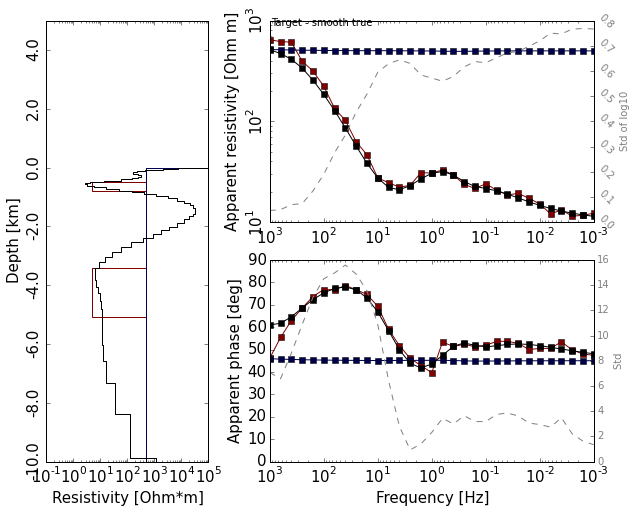

In [9]:
%matplotlib inline
fig = simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[m_0,mopt])
fig.suptitle('Target - smooth true')
plt.show()


In [10]:
reg.alpha_xx = 0.001
saveModel.fileName = 'Inversion_TargMisEqnD_smoothTrue_Wxx'

In [11]:
moptWxx = inv.run(m_0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_TargMisEqnD_smoothTrue_Wxx.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.00e+05  2.18e+05  0.00e+00  2.18e+05    4.01e+04      0              
   1  2.00e+05  2.52e+04  3.34e-05  2.52e+04    6.20e+03      0              
   2  2.00e+05  3.46e+03  1.33e-04  3.49e+03    1.03e+03      0   Skip BFGS  
   3  2.49e+04  1.72e+03  8.63e-04  1.74e+03    2.61e+02      0   Skip BFGS  
   4  2.49e+04  1.02e+03  1.30e-02  1.35e+03    2.51e+02      0   Skip BFGS  
   5  2.49e+04  6.65e+02  1.68e-02  1.08e+03    1.37e+02      0              
   6  3.12e+03  5.70e+02  1.88e-02  6.28e+02    1.17e+02   

array([ -4.14711455,  -8.48909373,  -7.52827336,  -3.49932909,
        -1.00331819,  -2.70007482,  -3.1711545 ,  -3.00405765,
        -2.7650382 ,  -2.66048875,  -2.66349897,  -2.71130228,
        -2.77717345,  -2.7947959 ,  -2.66720877,  -2.36129372,
        -1.99640404,  -1.65920128,  -1.57027047,  -1.94765493,
        -2.75336364,  -3.7261836 ,  -4.91018688,  -6.25134639,
        -7.7042116 ,  -9.04768822, -10.22631443, -11.38316489,
       -12.47719857, -13.45601604, -14.16107916, -14.62352295,
       -14.8899775 , -14.90719522, -14.61381454, -14.01919889,
       -13.24084833, -12.17168104, -10.79110293,  -9.09917198,
        -7.36420672,  -5.75429753,  -4.14109747,  -2.68084574,
        -1.58271625,  -1.1145424 ,  -1.14047311,  -1.70470304,
        -2.80682095,  -4.11322574,  -5.17550422,  -5.9471688 ,
        -6.43756507,  -6.50919184,  -6.12669826,  -5.55246011,
        -5.10992856,  -4.95756043,  -5.27203799,  -6.08576941,
        -7.12571201,  -8.10996496,  -9.02794122,  -9.72

In [13]:
moptWxx = Out[11]

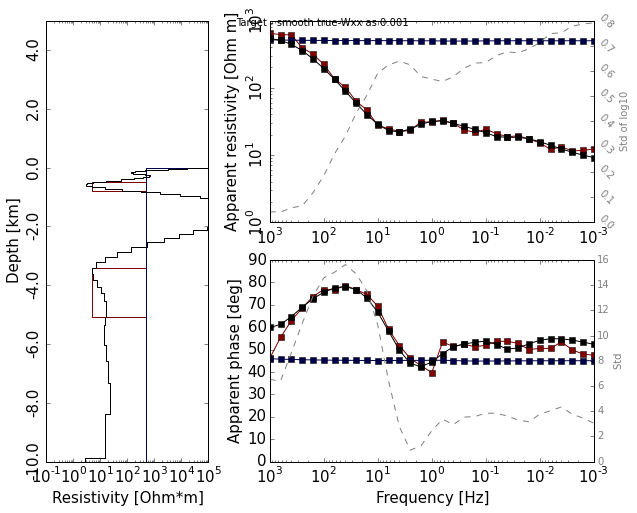

In [14]:
%matplotlib inline
fig = simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[m_0,moptWxx])
fig.suptitle('Target - smooth true-Wxx as 0.001')
plt.show()